# # 数据集验证工具使用示例
# 
# 本Notebook详细演示如何使用`DatasetValidator`数据集验证工具，对多视角物体重建、NOCS估计、6D姿态估计等任务的数据集进行全面的完整性和可视化检查。  
# 
# 主要功能和可视化内容包括：
# 
# 1. **RGB图像可视化**  
#    - 展示每一帧的原始RGB图像，便于直观检查图像内容是否正确加载。
# 
# 2. **深度图可视化**  
#    - 以伪彩色方式显示深度图，辅助判断深度信息的有效性和分布。
# 
# 3. **NOCS map可视化**  
#    - 展示NOCS（Normalized Object Coordinate Space）map，检查NOCS编码是否合理。
# 
# 4. **掩码可视化**  
#    - 显示可见掩码（visible_masks），并在前景区域标注对应的实例ID，便于核查掩码分割和实例分布。
# 
# 5. **相机轨迹可视化**  
#    - 三维空间中绘制相机的外参轨迹，直观展示相机运动路径，辅助发现外参异常。
# 
# 6. **实例ID分布统计**  
#    - 统计并可视化场景中所有实例ID的分布，检查实例标注的完整性和合理性。
# 
# 7. **点云可视化**  
#    - 支持三维点云的可视化（如scene_points、nocs_points、depth_points、bbox等），便于空间结构和点云质量检查。
# 
# 8. **三维包围盒（bbox）可视化**  
#    - 在点云中绘制每个物体的3D包围盒，并用有向箭头清晰表示bbox的位姿（局部坐标系），辅助验证6D姿态标注的准确性。
# 
# 9. **多视角一致性检查**  
#    - 检查多帧/多视角下的图像、深度、NOCS、掩码、外参等数据的一致性，发现潜在的同步或标注错误。
# 
# 10. **数据字段完整性与异常检测**  
#     - 自动检查数据集各字段（如scene_colors、scene_depths、nocs_maps、visible_masks、extrinsics、bbox等）是否存在、格式是否正确、数据是否为全零或异常值，并给出详细提示。
# 
# 11. **交互式可视化与保存**  
#     - 支持将可视化结果保存为图片，或在Notebook中交互式浏览，便于人工复查和问题定位。
# 
# 12. **典型异常案例提示**  
#     - 对于常见的数据异常（如全零图像、掩码缺失、外参全零、点云无效、bbox缺失等），工具会自动高亮并给出中文提示，帮助快速定位问题。
# 
# 通过上述多维度的可视化和自动检查，`DatasetValidator`能够极大提升数据集构建和标注的可靠性，降低后续训练和评测中的数据隐患。
# 
# **推荐流程：**
# 1. 加载数据集（支持.npz、.jsonl等格式）。
# 2. 使用`DatasetValidator`进行字段检查和可视化。
# 3. 根据可视化结果和自动提示，修正数据异常。
# 4. 确认所有字段和可视化内容均正常后，进入模型训练或评测流程。
# 
# > **提示：**  
# > - 本工具支持自定义扩展新的可视化内容。  
# > - 支持批量处理和单个场景逐步检查。  
# > - 可与Open3D、Plotly等三维可视化库结合，获得更丰富的交互体验。
# 
# ---
# 
# **下面将以真实数据为例，演示完整的验证和可视化流程。**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataset_validator import DatasetValidator
import open3d as o3d
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


## 1. 创建示例数据集

这里创建一个包含示例数据的场景数据字典，用于演示验证功能。

In [12]:
# 加载真实数据
print("📂 加载真实数据集...")
scene_data = np.load("/baai-cwm-vepfs/cwm/zheng.geng/code/nocs/vggt/data/rl_data/0.npz", allow_pickle=True)

# 显示数据集信息
print("📊 数据集信息:")
print(f"数据集包含的字段: {list(scene_data.keys())}")
print(f"数据类型: {type(scene_data)}")

# 显示每个字段的形状
for key in scene_data.keys():
    data = scene_data[key]
    if hasattr(data, 'shape'):
        print(f"{key}: {data.shape} ({data.dtype})")
    else:
        print(f"{key}: {type(data)}")

📂 加载真实数据集...
📊 数据集信息:
数据集包含的字段: ['scene_colors', 'scene_points', 'scene_depths', 'extrinsics', 'intrinsics', 'scene_scales', 'scene_poses', 'visual_masks', 'masks', 'nocs_maps', 'scene_instance_ids', 'model_list', 'bbox', 'is_directional']
数据类型: <class 'numpy.lib.npyio.NpzFile'>
scene_colors: (1, 1080, 1920, 3) (uint8)
scene_points: (1, 1080, 1920, 3) (float32)
scene_depths: (1, 1080, 1920) (float32)
extrinsics: (1, 4, 4) (float64)
intrinsics: (1, 3, 3) (float32)
scene_scales: (2, 3) (float64)
scene_poses: () (object)
visual_masks: (1, 1080, 1920) (uint8)
masks: () (object)
nocs_maps: (1, 1080, 1920, 3) (uint8)
scene_instance_ids: () (object)
model_list: (2,) (<U24)
bbox: () (object)
is_directional: (2, 3) (bool)


## 2. 创建验证器并执行验证

使用DatasetValidator类对数据集进行全面验证。

In [13]:
# 创建验证器
validator = DatasetValidator(scene_data)

# 执行所有验证检查
print("🔍 开始数据集验证...")
results = validator.validate_all()

print("\n📊 验证完成！")


🔍 开始数据集验证...
🔍 开始数据集验证...
🎨 验证RGB图像数据...
✅ RGB图像数据验证通过
🌐 验证3D点云数据...
✅ 3D点云数据验证通过
📏 验证深度图数据...
✅ 深度图数据验证通过
📷 验证相机参数...
✅ 相机参数验证通过
📐 验证场景尺度...
✅ 场景尺度验证通过
🔄 验证场景姿态...
✅ 场景姿态验证通过
🎭 验证掩码数据...
🗺️ 验证NOCS地图...
✅ NOCS地图验证通过
🆔 验证场景实例ID...
✅ 场景实例ID验证通过
📋 验证模型列表...
✅ 模型列表验证通过
📦 验证边界框数据...
✅ 边界框数据验证通过
🔗 验证数据一致性...
✅ 数据一致性验证通过

📊 数据集验证报告
总检查项: 11
通过检查: 11
失败检查: 0
错误数量: 1
警告数量: 2

❌ 错误列表:
  1. 缺少掩码字段: 'visible_masks is not a file in the archive'

⚠️ 警告列表:
  1. model_list数据类型应为object, 实际<U24
  2. model_list长度应为4, 实际2


📊 验证完成！


## 3. 生成可视化报告

创建详细的可视化图表来展示数据集的状态和问题。

🎨 生成数据可视化...

🎨 生成数据可视化...
📊 可视化图表已保存至: /baai-cwm-vepfs/cwm/zheng.geng/code/nocs/vggt/tools/dataset_validation_report.png


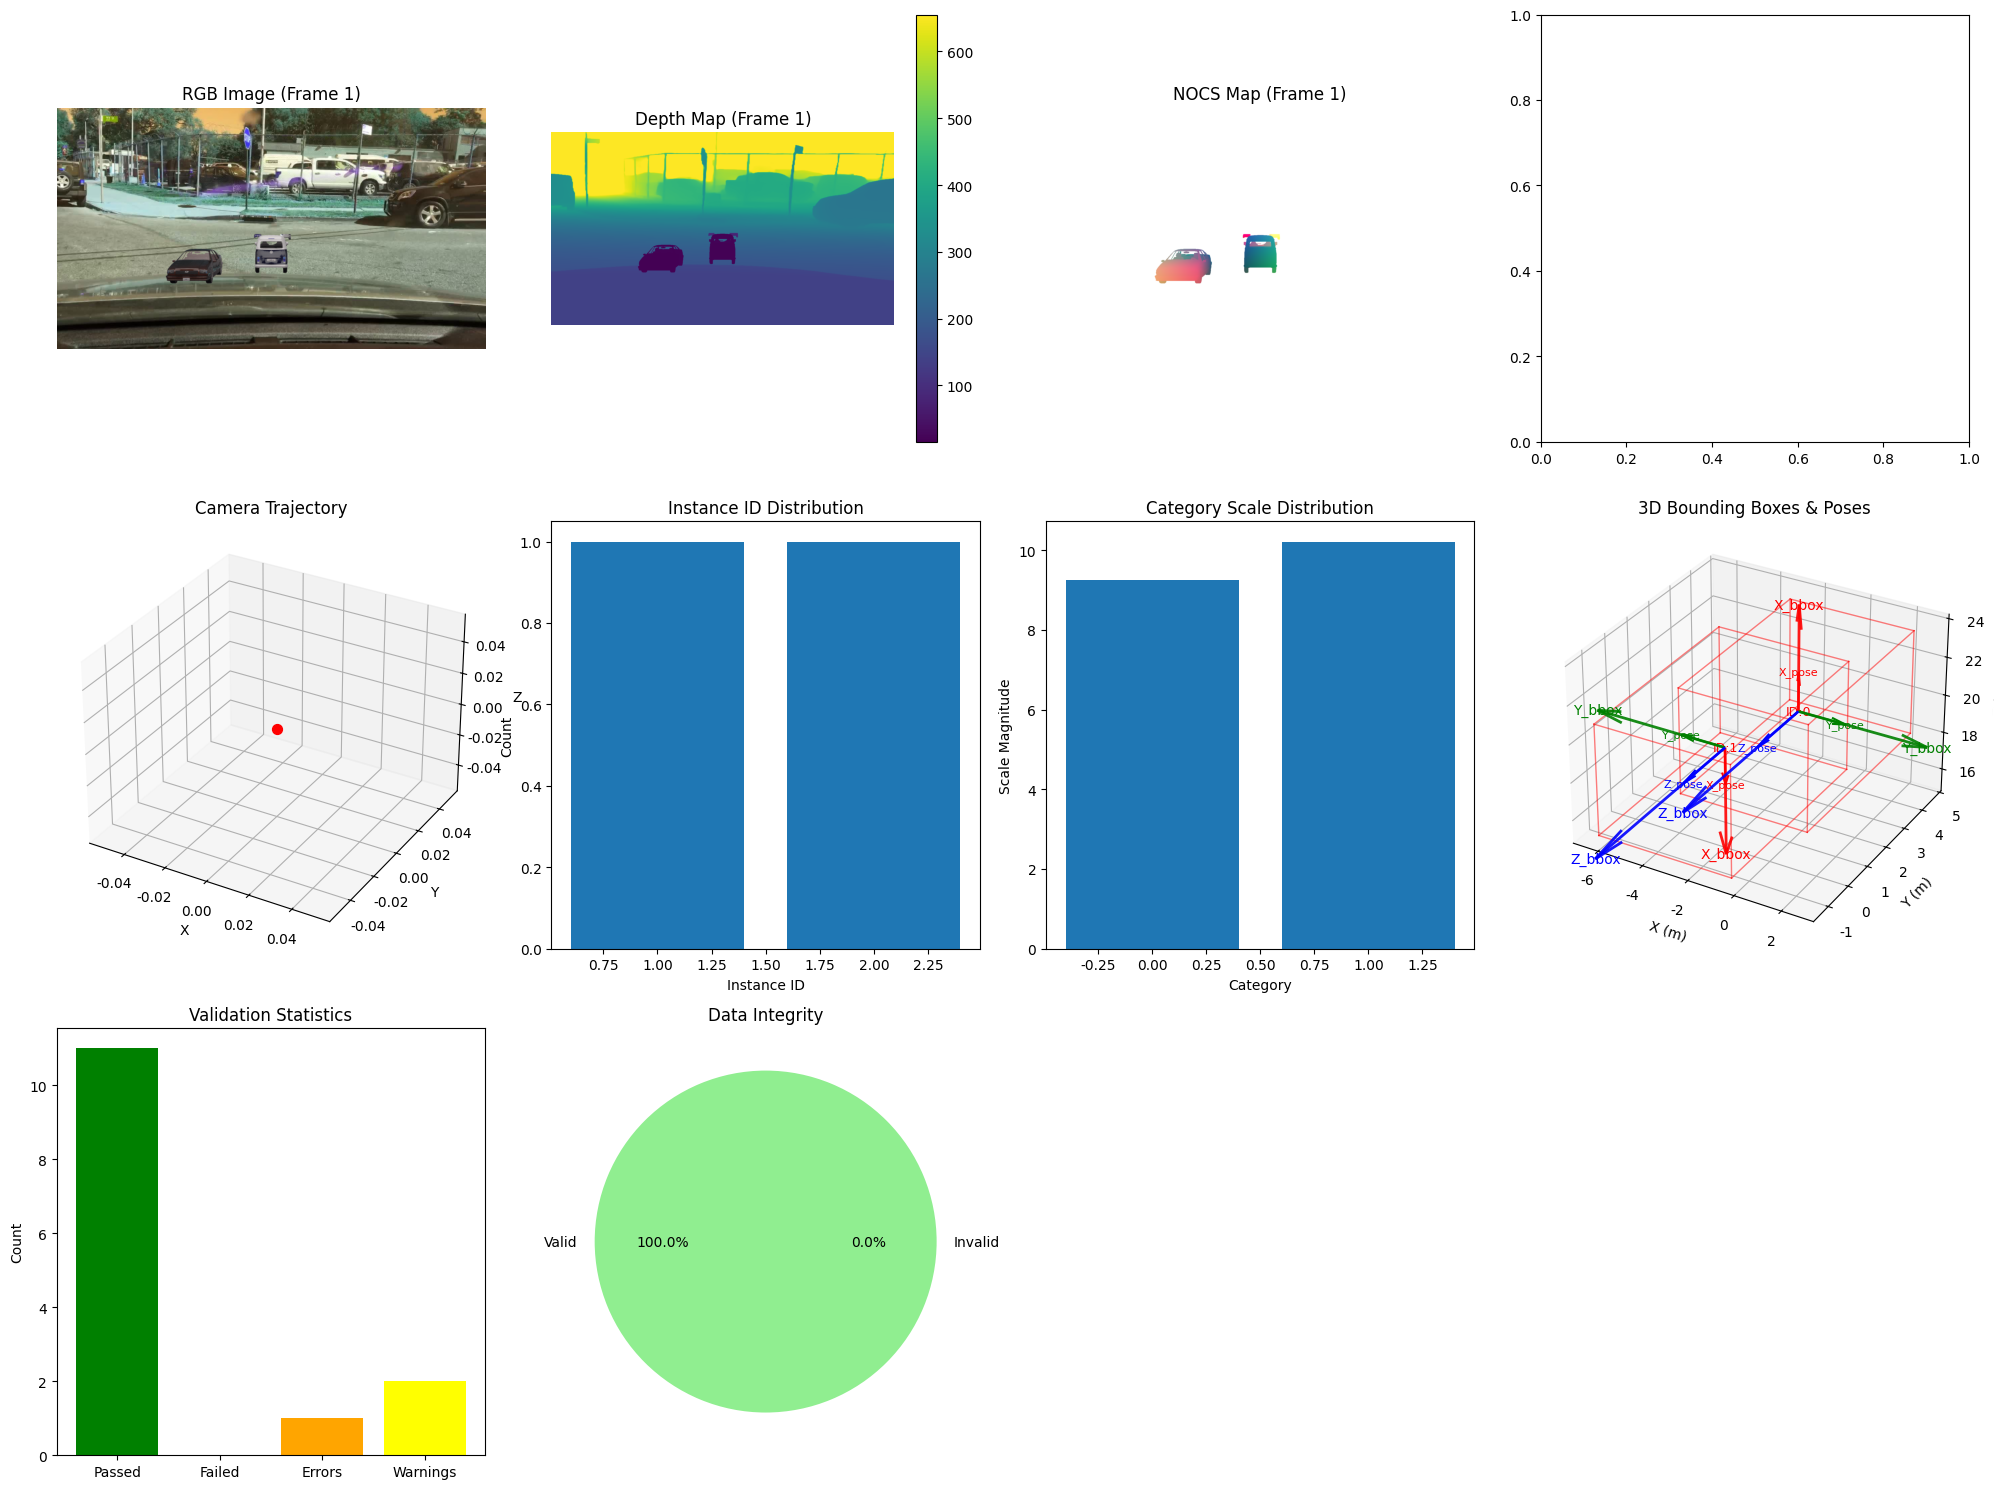

✅ 可视化报告生成完成
此处你应当查看：1，colors和depth是否正确；2，nocs是否正确；3，mask是否正确（如果两车有重养，visible mask谁在前面显示谁mask则均为全部显示(即使被遮挡部分)）；4，bbox的方向是否正确（z_bbox和z_pose朝向相机坐标系的y的负方向，x_bbox和x_pose朝向车头方向），和nocs定义相互匹配


In [ ]:
# 生成可视化报告
print("🎨 正在生成数据可视化报告...")
validator.visualize_data('/baai-cwm-vepfs/cwm/zheng.geng/code/nocs/vggt/tools/dataset_validation_report.png')
print("✅ 可视化报告已生成")

print(
    "请重点检查以下内容：\n"
    "1. colors（颜色）和 depth（深度）是否正确对应；\n"
    "2. nocs（归一化坐标空间）是否正确；\n"
    "3. mask（掩码）是否正确：若有两辆车重叠，visible mask 应该前景物体的 mask 完整显示（即使被遮挡部分也应显示），而不是被遮挡后消失；\n"
    "4. bbox（3D边界框）方向是否正确：z_bbox 和 z_pose 应指向相机坐标系的 y 轴负方向，x_bbox 和 x_pose 应指向车辆前进方向，且与 nocs 定义保持一致。"
)


# 可视化内容包括：场景点云、边界框点云、深度点云、NOCS点云及其缩放关系、位姿信息等

In [15]:
scene_instance_ids_0 = scene_data['scene_instance_ids'][()]['0000']
visible_masks_0 = scene_data['visual_masks'][0].reshape(-1)
mask_nocs_0 = visible_masks_0 == scene_instance_ids_0[0]
mask_nocs_1 = visible_masks_0 == scene_instance_ids_0[1]

In [ ]:
"""本段代码用于可视化3D点云数据，包括nocs点云、scene_points点云以及3D边界框。可根据Jupyter环境自动选择open3d WebVisualizer或plotly进行展示。"""
print("\n🎨 正在生成 NOCS 点云的三维可视化...")
print("请重点检查：点云是否严格符合 NOCS 定义（即归一化坐标空间的分布和范围是否正确）")

# 可视化nocs_maps
nocs_maps = scene_data['nocs_maps']
nocs_colors = scene_data['scene_colors']
nocs = nocs_maps[0]
colors = nocs_colors[0]
h, w, _ = nocs.shape
nocs_points = nocs.reshape(-1, 3).astype(np.float32) / 255.0
nocs_colors = colors.reshape(-1, 3).astype(np.float32) / 255.0
nocs_points = nocs_points[mask_nocs_0]
nocs_colors = nocs_colors[mask_nocs_0]

# 用open3d创建点云
pcd_nocs = o3d.geometry.PointCloud()
pcd_nocs.points = o3d.utility.Vector3dVector(nocs_points)
pcd_nocs.colors = o3d.utility.Vector3dVector(nocs_colors)

# 优先使用WebVisualizer（Jupyter），否则用draw_plotly
# o3d.visualization.draw_plotly([pcd_nocs])


🎨 生成nocs点云数据可视化...
此处你应当查看：是否符合nocs定义


In [ ]:
# 可视化 scene_points：本步骤将从所有点中随机采样最多80000个点进行展示，并同时渲染每个物体的3D边界框（bbox）及其局部坐标轴方向。
print("请重点关注：scene_points 是否包含所有物体的点云（包括被遮挡部分），以及 bbox 的位置、尺寸和朝向是否与点云严格对应。")
scene_points = scene_data['scene_points']
scene_colors = scene_data['scene_colors']

pts = scene_points[0].reshape(-1, 3)
colors = scene_colors[0].reshape(-1, 3) / 255.0

# 过滤掉全零点
valid_mask = ~(np.all(pts == 0, axis=1))
pts_valid = pts[valid_mask]
colors_valid = colors[valid_mask]

# 随机采样80000个点
num_points = pts_valid.shape[0]
sample_num = min(80000, num_points)
if num_points > 0:
    idx = np.random.choice(num_points, sample_num, replace=False)
    pts_sampled = pts_valid[idx]
    colors_sampled = colors_valid[idx]
else:
    pts_sampled = np.zeros((0, 3))
    colors_sampled = np.zeros((0, 3))

pcd_scene = o3d.geometry.PointCloud()
pcd_scene.points = o3d.utility.Vector3dVector(pts_sampled)
pcd_scene.colors = o3d.utility.Vector3dVector(colors_sampled)
print(f"scene_points点云已生成，展示{pts_sampled.shape[0]}个点。")

# 渲染bbox
bbox_objs = []
bbox_dict = scene_data['bbox'][()]['0000']
for inst_id, bbox in bbox_dict.items():
    # 获取中心和尺寸
    cx, cy, cz = bbox['x'], bbox['y'], bbox['z']
    w, h, l = bbox['w'], bbox['h'], bbox['l']
    R = bbox['R']  # (3,3)
    center = np.array([cx, cy, cz])
    extent = np.array([w, h, l])
    # 创建open3d的OrientedBoundingBox
    obb = o3d.geometry.OrientedBoundingBox(center, R, extent)
    obb.color = (1, 0, 0)  # 红色
    bbox_objs.append(obb)
    # 绘制xyz方向
    axis_length = max(w, h, l) * 0.6
    axes = np.eye(3) * axis_length
    axes = R @ axes
    origin = center
    x_axis = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector([origin, origin + axes[:, 0]]),
        lines=o3d.utility.Vector2iVector([[0, 1]])
    )
    x_axis.colors = o3d.utility.Vector3dVector([[1, 0, 0]])  # x-红
    y_axis = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector([origin, origin + axes[:, 1]]),
        lines=o3d.utility.Vector2iVector([[0, 1]])
    )
    y_axis.colors = o3d.utility.Vector3dVector([[0, 1, 0]])  # y-绿
    z_axis = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector([origin, origin + axes[:, 2]]),
        lines=o3d.utility.Vector2iVector([[0, 1]])
    )
    z_axis.colors = o3d.utility.Vector3dVector([[0, 0, 1]])  # z-蓝
    bbox_objs.extend([x_axis, y_axis, z_axis])

# 展示点云+bbox+xyz方向
# o3d.visualization.draw_plotly([pcd_scene] + bbox_objs)

此处你应当查看：是否符合scene_points定义(包括渲染物体的全部点)；bbox是否和这些点匹配
scene_points点云已生成，展示80000个点。


In [18]:
# 根据depth和intrinsic恢复点云并可视化
# 获取depth和intrinsic
print("此处你应当查看：是否符合depth定义(包括渲染物体的全部点)；是否和前面的world_points匹配；bbox是否是响应点的紧包围盒")
depth = scene_data['scene_depths'][0]  # (1080, 1920)
K = scene_data['intrinsics'][0]        # (3, 3)

H, W = depth.shape
fx, fy = K[0, 0], K[1, 1]
cx, cy = K[0, 2], K[1, 2]

# 构建像素网格
u, v = np.meshgrid(np.arange(W), np.arange(H))
u = u.astype(np.float32)
v = v.astype(np.float32)

# 反投影公式
z = depth
x = (u - cx) * z / fx
y = (v - cy) * z / fy

points = np.stack([x, y, z], axis=-1).reshape(-1, 3)

# 过滤掉z为0的点
valid_mask = (z < 25).reshape(-1)
points_valid = points[valid_mask]

# 采样可视化点数
sample_num = min(80000, points_valid.shape[0])
if points_valid.shape[0] > 0:
    idx = np.random.choice(points_valid.shape[0], sample_num, replace=False)
    points_sampled = points_valid[idx]
else:
    points_sampled = np.zeros((0, 3))

# 颜色（可选：用scene_colors或灰度）
if 'scene_colors' in scene_data:
    colors = scene_data['scene_colors'][0].reshape(-1, 3) / 255.0
    colors_valid = colors[valid_mask]
    if points_valid.shape[0] > 0:
        colors_sampled = colors_valid[idx]
    else:
        colors_sampled = np.zeros((0, 3))
else:
    # 若无颜色，使用灰度
    gray = np.repeat((z / z.max()).reshape(-1, 1), 3, axis=1)
    colors_sampled = gray[valid_mask][idx] if points_valid.shape[0] > 0 else np.zeros((0, 3))

# 构建点云
pcd_depth = o3d.geometry.PointCloud()
pcd_depth.points = o3d.utility.Vector3dVector(points_sampled)
pcd_depth.colors = o3d.utility.Vector3dVector(colors_sampled)
print(f"由depth恢复点云，展示{points_sampled.shape[0]}个点。")

# ====== 新增：bbox边线离散为点云可视化 ======
bbox_objs = []
bbox_points = []
bbox_colors = []

bbox_dict = scene_data['bbox'][()]['0000']
for inst_id, bbox in bbox_dict.items():
    # 获取中心和尺寸
    cx, cy, cz = bbox['x'], bbox['y'], bbox['z']
    w, h, l = bbox['w'], bbox['h'], bbox['l']
    R = bbox['R']  # (3,3)
    center = np.array([cx, cy, cz])
    extent = np.array([w, h, l])

    # 计算8个顶点（以中心为原点，长宽高分别为l,w,h）
    # 参考construct_data.ipynb注释，l为x方向，w为y方向，h为z方向
    corners = np.array([
        [ l/2,  w/2,  h/2],
        [ l/2, -w/2,  h/2],
        [-l/2, -w/2,  h/2],
        [-l/2,  w/2,  h/2],
        [ l/2,  w/2, -h/2],
        [ l/2, -w/2, -h/2],
        [-l/2, -w/2, -h/2],
        [-l/2,  w/2, -h/2],
    ], dtype=np.float32)
    # 旋转+平移
    corners = (R @ corners.T).T + center

    # 边的连接顺序
    edges = [
        (0,1),(1,2),(2,3),(3,0), # 上面
        (4,5),(5,6),(6,7),(7,4), # 下面
        (0,4),(1,5),(2,6),(3,7)  # 竖线
    ]
    # 每条边离散为若干点
    num_edge_points = 50
    for s, e in edges:
        p1 = corners[s]
        p2 = corners[e]
        edge_points = np.linspace(p1, p2, num_edge_points)
        bbox_points.append(edge_points)
        bbox_colors.append(np.tile(np.array([[1, 0, 0]]), (num_edge_points, 1)))  # 红色

# 合并所有bbox边线点
bbox_points = np.concatenate(bbox_points, axis=0)
bbox_colors = np.concatenate(bbox_colors, axis=0)
pcd_bbox = o3d.geometry.PointCloud()
pcd_bbox.points = o3d.utility.Vector3dVector(bbox_points)
pcd_bbox.colors = o3d.utility.Vector3dVector(bbox_colors)
print(f"bbox边线点云可视化，展示{bbox_points.shape[0]}个点。")
o3d.visualization.draw_plotly([pcd_depth, pcd_bbox])


此处你应当查看：是否符合depth定义(包括渲染物体的全部点)；是否和前面的world_points匹配；bbox是否是响应点的紧包围盒
由depth恢复点云，展示48738个点。
bbox边线点云可视化，展示1200个点。


In [19]:
# 可视化nocs_maps并将其变换到世界坐标系
print('此处你应当查看nocs的位姿和scale是否准确，即nocs根据scale和pose变换后是否与depth_points重合')
nocs_maps = scene_data['nocs_maps']
nocs_colors = scene_data['scene_colors']
scene_scales = scene_data['scene_scales']  # (2, 3)
scene_poses = scene_data['scene_poses']    # dict, 每帧有2个物体的4x4 pose

nocs = nocs_maps[0]        # (H, W, 3)
colors = nocs_colors[0]    # (H, W, 3)
h, w, _ = nocs.shape

nocs_points = nocs.reshape(-1, 3).astype(np.float32) / 255.0
nocs_points -= 0.5  # NOCS中心化

nocs_colors_flat = colors.reshape(-1, 3).astype(np.float32) / 255.0

# 只保留有效点
mask = nocs_points.sum(axis=1) < 2.95
nocs_points = nocs_points[mask_nocs_0]
nocs_colors_flat = nocs_colors_flat[mask_nocs_0]

if nocs_points.shape[0] > sample_num:
    random_mask = np.random.choice(nocs_points.shape[0], sample_num, replace=False)
    nocs_points = nocs_points[random_mask]
    nocs_colors_flat = nocs_colors_flat[random_mask]

# 获取该帧的pose
poses = scene_poses[()]['0000']  # (2, 4, 4)
# 获取该帧的scale
scales = scene_scales  # (2, 3)

# 假设nocs_maps的第0通道为第0个物体，第1通道为第1个物体（如有mask可进一步筛选）
# 这里假设每个像素点属于第0个物体（可根据mask进一步细分）

# 这里以第0个物体为例
obj_idx = 0
obj_scale = scales[obj_idx]  # (3,)
obj_pose = poses[obj_idx]    # (4, 4)

# 对nocs点云进行缩放
nocs_points_scaled = nocs_points * obj_scale  # (N, 3)

# 齐次化
nocs_points_homo = np.concatenate([nocs_points_scaled, np.ones((nocs_points_scaled.shape[0], 1), dtype=np.float32)], axis=1)  # (N, 4)

# 应用位姿变换
nocs_points_world = (obj_pose @ nocs_points_homo.T).T[:, :3]  # (N, 3)

# 构建点云
nocs_scene = o3d.geometry.PointCloud()
nocs_scene.points = o3d.utility.Vector3dVector(nocs_points_world)
nocs_scene.colors = o3d.utility.Vector3dVector(nocs_colors_flat)

print(f"展示NOCS点云经过缩放和位姿变换后的{nocs_points_world.shape[0]}个点。")
# 给每个点云设置不同的颜色和名称，便于区分
import copy
pcd_depth_temp = copy.deepcopy(pcd_depth)
nocs_scene_temp = copy.deepcopy(nocs_scene)

# 给pcd_depth设置为蓝色
pcd_depth_temp.paint_uniform_color([0, 0.5, 1.0])
# nocs_scene保持原有颜色

o3d.visualization.draw_plotly(
    [pcd_depth_temp, nocs_scene_temp]
)

此处你应当查看nocs的位姿和scale是否准确，即nocs根据scale和pose变换后是否与depth_points重合
展示NOCS点云经过缩放和位姿变换后的21474个点。
